Pretrained spectrogram classification model using simulated dataset

In [6]:
import torch
import glob
import os
import cv2
from tqdm import tqdm
import numpy as np
from torchvision.transforms import transforms
from data import MyDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
lr, num_epoch = 0.001, 100

train_path = './train/' # 3*60 simulated imgs copied from <https://github.com/Jcq242818/CASTER/tree/retraining2/model1/train>
test_path = './test/' # 3*40 real test imgs copied from <https://github.com/Jcq242818/CASTER/tree/retraining2/model1/test>
train_txt_path = './train/train.txt'
test_txt_path = './test/test.txt'
output_path = './output_source'
log_path = './output_source/log'

train_all = {}
test_all = {}
for trainable in [True,False]:
    if trainable:
        for category in ['pic1','pic2','pic3']:
            train_all[category] = glob.glob(os.path.join(train_path + category,'*.jpg'))
    else:
        for category in ['pic1','pic2','pic3']:
            test_all[category] = glob.glob(os.path.join(test_path + category,'*.jpg'))

mapkey = {
    'pic1' : '0',
    'pic2' : '1',
    'pic3' : '2',
}

def gen_txt(txt_path, img_paths):
    f = open(txt_path,'w')
    for key in img_paths.keys():
        label = mapkey[key]
        for path in img_paths[key]:
            line = path + ' ' + label +'\n'
            f.write(line)

gen_txt(train_txt_path,train_all)
gen_txt(test_txt_path,test_all)

if not os.path.exists(output_path):
    os.makedirs(output_path)

if os.path.exists(log_path):
    import shutil
    shutil.rmtree(log_path)
tb = SummaryWriter(log_dir=log_path)

train_paths = train_all['pic1'] + train_all['pic2'] + train_all['pic3']
m_list, s_list = [], []

for path in tqdm(train_paths):  # tqdm进度条模式，挺有意思的
    img = cv2.imread(path)
    img = img / 255.0
    m, s = cv2.meanStdDev(img)
    m_list.append(m.reshape((3,)))
    s_list.append(s.reshape((3,)))

m_array = np.array(m_list)
s_array = np.array(s_list)
m = m_array.mean(axis=0, keepdims=True)
s = s_array.mean(axis=0, keepdims=True)
normMean = m[0][::-1].copy()
normStd = s[0][::-1].copy()
normTransform = transforms.Normalize(normMean, normStd)
trainTransform = transforms.Compose([
    transforms.ToTensor(),
    normTransform,
])
testTransform = transforms.Compose([
    transforms.ToTensor(),
    normTransform,
])

train_data = MyDataset(txt_path=train_txt_path, transform=trainTransform)
test_data = MyDataset(txt_path=test_txt_path, transform=testTransform)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

100%|██████████| 180/180 [00:00<00:00, 5179.54it/s]


In [8]:
from torchvision.models.resnet import resnet18
from torch import nn, optim, tensor
import torch.nn.functional as nf
import pandas as pd
import d2lzh_pytorch as d2l
from models import fc_part

model = resnet18(pretrained=True).to(device)
model.fc = fc_part().to(device)
model.load_state_dict(torch.load('./model1/best_resnet18_model.pth'))

ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())
optimizer = optim.SGD([
    {'params': base_params},
    {'params': model.fc.parameters(), 'lr': lr*10}], lr, momentum=0.9, weight_decay=1e-4)

/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
from utils import plot_confusion_matrix
from matplotlib import pyplot as plt
import csv

def train_gesture(model, train_loader, test_loader, optimizer, device, num_epoch):
    print("training on ", device)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    test_epoch_list = []
    test_acc_list = []
    best_pred_list_total = []
    best_epoch = 0
    best_test_accuracy = torch.Tensor([0.0])
    
    for epoch in range(1, num_epoch+1):
        print(epoch, '\n')
        train_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        predicted_list = []
        labels_list = []
        scheduler.step()

        with tqdm(train_loader, desc='Train') as t:
            model.train()
            for data in t:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                l = nf.cross_entropy(outputs, labels)
                l.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, axis=1)
                train_total += labels.size(0)
                train_correct += torch.sum(predicted == labels).item()
                train_loss += l.item()
                t.set_postfix(train_loss=l.item(),train_accuracy=train_correct/train_total)
        test_loss = 0.0
        test_correct = 0.0
        test_total = 0.0

        with torch.no_grad():
            model.eval()
            with tqdm(test_loader, desc='Test') as t:
                for data in t:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model.forward(inputs)
                    l = nf.cross_entropy(outputs, labels)
                    test_loss += l.item()

                    _, predicted = torch.max(outputs, axis=1)

                    predicted_list.append(predicted)
                    labels_list.append(labels)

                    test_total += labels.size(0)
                    test_correct += torch.sum(predicted == labels).item()
                    t.set_postfix(test_loss=l.item(),test_accuracy=test_correct / test_total)
           
        tb.add_scalar('train_loss', train_loss/train_total, epoch)
        tb.add_scalar('train_accuracy', train_correct/train_total, epoch)
        tb.add_scalar('test_loss', test_loss/test_total, epoch)
        tb.add_scalar('test_accuracy', test_correct/test_total, epoch)
        test_acc_each_epoch = test_correct/test_total
        test_epoch_list.append(epoch)
        test_acc_list.append(test_acc_each_epoch)
        test_acc_each_epoch = 0
        predicted_list = [aa.tolist() for aa in predicted_list]
        pred_list_total = [i for item in predicted_list for i in item]
        labels_list = [aa.tolist() for aa in labels_list]
        labels_list_total = [i for item in labels_list for i in item]
        train_acc_sum = torch.tensor([round(train_correct/train_total, 5)])
        test_acc = torch.tensor([test_correct/test_total])
        if epoch == 1:
            train_acc_all = train_acc_sum
            test_acc_all = test_acc
        else:
            train_acc_all = torch.cat([train_acc_all, train_acc_sum])
            test_acc_all = torch.cat([test_acc_all, test_acc])
        # 最佳epoch的模型    
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
            best_epoch = epoch
            best_pred_list_total = pred_list_total.copy()
            torch.save(model.state_dict(), output_path+'/best_resnet18_model.pth')
        tb.add_scalar('best accuracy',best_test_accuracy.numpy(),epoch)
        tb.add_scalar('best_epoch',best_epoch,epoch)
        print('best accuracy: {}, best epoch: {}'.format(best_test_accuracy.numpy(),best_epoch))

    plot_confusion_matrix(labels_list_total,pred_list_total,['Push & Pull','Beckoned','Rub Fingers'],output_path + '/Train_ConfMatrix',normalize=True)
    plot_confusion_matrix(labels_list_total,best_pred_list_total,['Push & Pull','Beckoned','Rub Fingers'],output_path + '/Best_Train_ConfMatrix',normalize=True)

    train_acc_all = train_acc_all.tolist()
    test_acc_all = test_acc_all.tolist()

    plt.figure()
    d2l.semilogy(range(1, num_epoch+1), test_acc_all, 'epochs', 'acc')
    name = ['train_acc', 'test_acc']
    acc_file = pd.DataFrame(index=name, data=(train_acc_all, test_acc_all))
    acc_file.to_csv(output_path + '/test pred.csv', encoding='gbk')
    plt.show()
    torch.save(model.state_dict(), output_path+'/resnet18_model.pth')
    with open(output_path + '/test_acc.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for i in range(len(test_epoch_list)):
            row = [test_epoch_list[i], test_acc_list[i]]
            writer.writerow(row)

/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


training on  cuda
1 



Test: 100%|██████████| 8/8 [00:00<00:00, 73.61it/s, test_accuracy=0.867, test_loss=0.754]


best accuracy: [0.8666667], best epoch: 1
2 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.32it/s, test_accuracy=0.733, test_loss=0.827]


best accuracy: [0.8666667], best epoch: 1
3 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.09it/s, test_accuracy=0.717, test_loss=0.837]


best accuracy: [0.8666667], best epoch: 1
4 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.65it/s, test_accuracy=0.608, test_loss=1.39]


best accuracy: [0.8666667], best epoch: 1
5 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.13it/s, test_accuracy=0.65, test_loss=1.26] 


best accuracy: [0.8666667], best epoch: 1
6 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.20it/s, test_accuracy=0.733, test_loss=0.94]


best accuracy: [0.8666667], best epoch: 1
7 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.67it/s, test_accuracy=0.742, test_loss=1.1] 


best accuracy: [0.8666667], best epoch: 1
8 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.17it/s, test_accuracy=0.733, test_loss=1.29]


best accuracy: [0.8666667], best epoch: 1
9 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.77it/s, test_accuracy=0.742, test_loss=0.997]


best accuracy: [0.8666667], best epoch: 1
10 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.42it/s, test_accuracy=0.533, test_loss=2.93]


best accuracy: [0.8666667], best epoch: 1
11 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.59it/s, test_accuracy=0.908, test_loss=0.639]


best accuracy: [0.90833336], best epoch: 11
12 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.56it/s, test_accuracy=0.825, test_loss=0.768]


best accuracy: [0.90833336], best epoch: 11
13 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.99it/s, test_accuracy=0.733, test_loss=0.989]


best accuracy: [0.90833336], best epoch: 11
14 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.95it/s, test_accuracy=0.758, test_loss=1.3] 


best accuracy: [0.90833336], best epoch: 11
15 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.69it/s, test_accuracy=0.5, test_loss=2.31]  


best accuracy: [0.90833336], best epoch: 11
16 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.18it/s, test_accuracy=0.567, test_loss=1.38]


best accuracy: [0.90833336], best epoch: 11
17 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.82it/s, test_accuracy=0.675, test_loss=0.968]


best accuracy: [0.90833336], best epoch: 11
18 



Test: 100%|██████████| 8/8 [00:00<00:00, 60.44it/s, test_accuracy=0.75, test_loss=0.676]


best accuracy: [0.90833336], best epoch: 11
19 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.94it/s, test_accuracy=0.75, test_loss=0.464] 


best accuracy: [0.90833336], best epoch: 11
20 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.49it/s, test_accuracy=0.733, test_loss=0.402]


best accuracy: [0.90833336], best epoch: 11
21 



Test: 100%|██████████| 8/8 [00:00<00:00, 57.41it/s, test_accuracy=0.625, test_loss=0.966]


best accuracy: [0.90833336], best epoch: 11
22 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.90it/s, test_accuracy=0.617, test_loss=1.12]


best accuracy: [0.90833336], best epoch: 11
23 



Test: 100%|██████████| 8/8 [00:00<00:00, 54.71it/s, test_accuracy=0.625, test_loss=1.24]  


best accuracy: [0.90833336], best epoch: 11
24 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.96it/s, test_accuracy=0.508, test_loss=1.55]


best accuracy: [0.90833336], best epoch: 11
25 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.94it/s, test_accuracy=0.775, test_loss=0.741]


best accuracy: [0.90833336], best epoch: 11
26 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.01it/s, test_accuracy=0.717, test_loss=1.42]


best accuracy: [0.90833336], best epoch: 11
27 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.31it/s, test_accuracy=0.683, test_loss=1.27]


best accuracy: [0.90833336], best epoch: 11
28 



Test: 100%|██████████| 8/8 [00:00<00:00, 55.65it/s, test_accuracy=0.725, test_loss=0.507]


best accuracy: [0.90833336], best epoch: 11
29 



Test: 100%|██████████| 8/8 [00:00<00:00, 55.29it/s, test_accuracy=0.725, test_loss=0.524]


best accuracy: [0.90833336], best epoch: 11
30 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.58it/s, test_accuracy=0.758, test_loss=0.337]


best accuracy: [0.90833336], best epoch: 11
31 



Test: 100%|██████████| 8/8 [00:00<00:00, 60.49it/s, test_accuracy=0.758, test_loss=0.305]


best accuracy: [0.90833336], best epoch: 11
32 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.80it/s, test_accuracy=0.617, test_loss=0.0535]


best accuracy: [0.90833336], best epoch: 11
33 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.81it/s, test_accuracy=0.808, test_loss=0.172]


best accuracy: [0.90833336], best epoch: 11
34 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.72it/s, test_accuracy=0.683, test_loss=0.989]


best accuracy: [0.90833336], best epoch: 11
35 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.64it/s, test_accuracy=0.717, test_loss=1.05]


best accuracy: [0.90833336], best epoch: 11
36 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.19it/s, test_accuracy=0.75, test_loss=0.973]


best accuracy: [0.90833336], best epoch: 11
37 



Test: 100%|██████████| 8/8 [00:00<00:00, 55.04it/s, test_accuracy=0.783, test_loss=0.657]


best accuracy: [0.90833336], best epoch: 11
38 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.97it/s, test_accuracy=0.75, test_loss=0.88]  


best accuracy: [0.90833336], best epoch: 11
39 



Test: 100%|██████████| 8/8 [00:00<00:00, 55.01it/s, test_accuracy=0.725, test_loss=0.946]


best accuracy: [0.90833336], best epoch: 11
40 



Test: 100%|██████████| 8/8 [00:00<00:00, 56.33it/s, test_accuracy=0.692, test_loss=1.3] 


best accuracy: [0.90833336], best epoch: 11
41 



Test: 100%|██████████| 8/8 [00:00<00:00, 55.09it/s, test_accuracy=0.667, test_loss=1.35]


best accuracy: [0.90833336], best epoch: 11
42 



Test: 100%|██████████| 8/8 [00:00<00:00, 55.49it/s, test_accuracy=0.658, test_loss=1.47]


best accuracy: [0.90833336], best epoch: 11
43 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.06it/s, test_accuracy=0.625, test_loss=1.55]


best accuracy: [0.90833336], best epoch: 11
44 



Test: 100%|██████████| 8/8 [00:00<00:00, 54.94it/s, test_accuracy=0.775, test_loss=0.581]


best accuracy: [0.90833336], best epoch: 11
45 



Test: 100%|██████████| 8/8 [00:00<00:00, 54.35it/s, test_accuracy=0.775, test_loss=0.625]


best accuracy: [0.90833336], best epoch: 11
46 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.28it/s, test_accuracy=0.675, test_loss=1.11]


best accuracy: [0.90833336], best epoch: 11
47 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.17it/s, test_accuracy=0.683, test_loss=0.952]


best accuracy: [0.90833336], best epoch: 11
48 



Test: 100%|██████████| 8/8 [00:00<00:00, 57.69it/s, test_accuracy=0.608, test_loss=1.08]


best accuracy: [0.90833336], best epoch: 11
49 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.83it/s, test_accuracy=0.6, test_loss=1.22]  


best accuracy: [0.90833336], best epoch: 11
50 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.79it/s, test_accuracy=0.608, test_loss=1.25]


best accuracy: [0.90833336], best epoch: 11
51 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.59it/s, test_accuracy=0.6, test_loss=1.39]  


best accuracy: [0.90833336], best epoch: 11
52 



Test: 100%|██████████| 8/8 [00:00<00:00, 51.95it/s, test_accuracy=0.608, test_loss=1.05]


best accuracy: [0.90833336], best epoch: 11
53 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.02it/s, test_accuracy=0.65, test_loss=1.08] 


best accuracy: [0.90833336], best epoch: 11
54 



Test: 100%|██████████| 8/8 [00:00<00:00, 57.56it/s, test_accuracy=0.608, test_loss=1.16]


best accuracy: [0.90833336], best epoch: 11
55 



Test: 100%|██████████| 8/8 [00:00<00:00, 60.60it/s, test_accuracy=0.6, test_loss=1.31]  


best accuracy: [0.90833336], best epoch: 11
56 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.63it/s, test_accuracy=0.625, test_loss=1.1] 


best accuracy: [0.90833336], best epoch: 11
57 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.26it/s, test_accuracy=0.7, test_loss=1.01]  


best accuracy: [0.90833336], best epoch: 11
58 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.61it/s, test_accuracy=0.658, test_loss=1.05]


best accuracy: [0.90833336], best epoch: 11
59 



Test: 100%|██████████| 8/8 [00:00<00:00, 60.57it/s, test_accuracy=0.642, test_loss=1.2] 


best accuracy: [0.90833336], best epoch: 11
60 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.25it/s, test_accuracy=0.675, test_loss=1.05]


best accuracy: [0.90833336], best epoch: 11
61 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.96it/s, test_accuracy=0.708, test_loss=0.995]


best accuracy: [0.90833336], best epoch: 11
62 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.43it/s, test_accuracy=0.667, test_loss=0.917]


best accuracy: [0.90833336], best epoch: 11
63 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.56it/s, test_accuracy=0.742, test_loss=0.93]


best accuracy: [0.90833336], best epoch: 11
64 



Test: 100%|██████████| 8/8 [00:00<00:00, 60.13it/s, test_accuracy=0.708, test_loss=0.973]


best accuracy: [0.90833336], best epoch: 11
65 



Test: 100%|██████████| 8/8 [00:00<00:00, 60.14it/s, test_accuracy=0.692, test_loss=0.825]


best accuracy: [0.90833336], best epoch: 11
66 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.98it/s, test_accuracy=0.667, test_loss=0.986]


best accuracy: [0.90833336], best epoch: 11
67 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.66it/s, test_accuracy=0.625, test_loss=1.13]


best accuracy: [0.90833336], best epoch: 11
68 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.73it/s, test_accuracy=0.683, test_loss=0.963]


best accuracy: [0.90833336], best epoch: 11
69 



Test: 100%|██████████| 8/8 [00:00<00:00, 64.15it/s, test_accuracy=0.708, test_loss=0.999]


best accuracy: [0.90833336], best epoch: 11
70 



Test: 100%|██████████| 8/8 [00:00<00:00, 64.62it/s, test_accuracy=0.758, test_loss=0.919]


best accuracy: [0.90833336], best epoch: 11
71 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.76it/s, test_accuracy=0.717, test_loss=0.916]


best accuracy: [0.90833336], best epoch: 11
72 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.41it/s, test_accuracy=0.658, test_loss=1.22]


best accuracy: [0.90833336], best epoch: 11
73 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.43it/s, test_accuracy=0.692, test_loss=1.1] 


best accuracy: [0.90833336], best epoch: 11
74 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.20it/s, test_accuracy=0.658, test_loss=1.19]


best accuracy: [0.90833336], best epoch: 11
75 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.19it/s, test_accuracy=0.675, test_loss=1.16]


best accuracy: [0.90833336], best epoch: 11
76 



Test: 100%|██████████| 8/8 [00:00<00:00, 64.79it/s, test_accuracy=0.675, test_loss=1.15]


best accuracy: [0.90833336], best epoch: 11
77 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.31it/s, test_accuracy=0.708, test_loss=1.08]


best accuracy: [0.90833336], best epoch: 11
78 



Test: 100%|██████████| 8/8 [00:00<00:00, 57.68it/s, test_accuracy=0.708, test_loss=1]   


best accuracy: [0.90833336], best epoch: 11
79 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.82it/s, test_accuracy=0.692, test_loss=0.941]


best accuracy: [0.90833336], best epoch: 11
80 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.79it/s, test_accuracy=0.775, test_loss=0.752]


best accuracy: [0.90833336], best epoch: 11
81 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.46it/s, test_accuracy=0.733, test_loss=0.98]


best accuracy: [0.90833336], best epoch: 11
82 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.38it/s, test_accuracy=0.733, test_loss=0.9] 


best accuracy: [0.90833336], best epoch: 11
83 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.42it/s, test_accuracy=0.667, test_loss=1.08]


best accuracy: [0.90833336], best epoch: 11
84 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.05it/s, test_accuracy=0.65, test_loss=1.27] 


best accuracy: [0.90833336], best epoch: 11
85 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.05it/s, test_accuracy=0.633, test_loss=1.2] 


best accuracy: [0.90833336], best epoch: 11
86 



Test: 100%|██████████| 8/8 [00:00<00:00, 63.40it/s, test_accuracy=0.717, test_loss=1]   


best accuracy: [0.90833336], best epoch: 11
87 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.64it/s, test_accuracy=0.7, test_loss=1.16]  


best accuracy: [0.90833336], best epoch: 11
88 



Test: 100%|██████████| 8/8 [00:00<00:00, 58.21it/s, test_accuracy=0.725, test_loss=0.984]


best accuracy: [0.90833336], best epoch: 11
89 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.74it/s, test_accuracy=0.683, test_loss=1.21]


best accuracy: [0.90833336], best epoch: 11
90 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.79it/s, test_accuracy=0.708, test_loss=1.13]


best accuracy: [0.90833336], best epoch: 11
91 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.63it/s, test_accuracy=0.725, test_loss=0.955]


best accuracy: [0.90833336], best epoch: 11
92 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.05it/s, test_accuracy=0.733, test_loss=0.896]


best accuracy: [0.90833336], best epoch: 11
93 



Test: 100%|██████████| 8/8 [00:00<00:00, 59.92it/s, test_accuracy=0.767, test_loss=0.71] 


best accuracy: [0.90833336], best epoch: 11
94 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.11it/s, test_accuracy=0.75, test_loss=0.866] 


best accuracy: [0.90833336], best epoch: 11
95 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.41it/s, test_accuracy=0.767, test_loss=0.789]


best accuracy: [0.90833336], best epoch: 11
96 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.13it/s, test_accuracy=0.75, test_loss=0.879] 


best accuracy: [0.90833336], best epoch: 11
97 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.89it/s, test_accuracy=0.742, test_loss=0.948]


best accuracy: [0.90833336], best epoch: 11
98 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.60it/s, test_accuracy=0.725, test_loss=0.943]


best accuracy: [0.90833336], best epoch: 11
99 



Test: 100%|██████████| 8/8 [00:00<00:00, 62.36it/s, test_accuracy=0.742, test_loss=0.915]


best accuracy: [0.90833336], best epoch: 11
100 



Test: 100%|██████████| 8/8 [00:00<00:00, 61.14it/s, test_accuracy=0.808, test_loss=0.746]


best accuracy: [0.90833336], best epoch: 11
Normalized confusion matrix
[[0.8  0.2  0.  ]
 [0.02 0.98 0.  ]
 [0.02 0.32 0.65]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.02 0.88 0.1 ]
 [0.   0.15 0.85]]


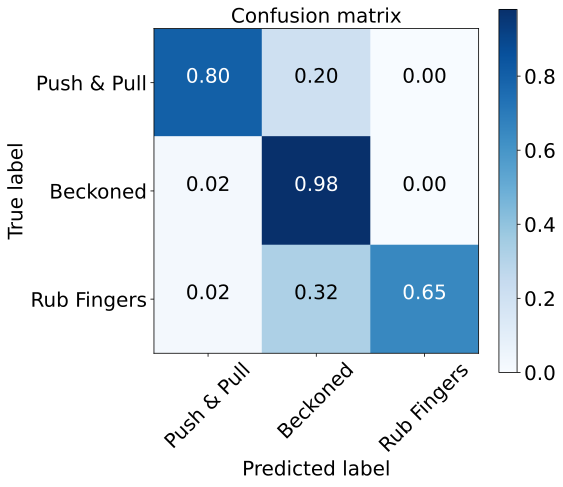

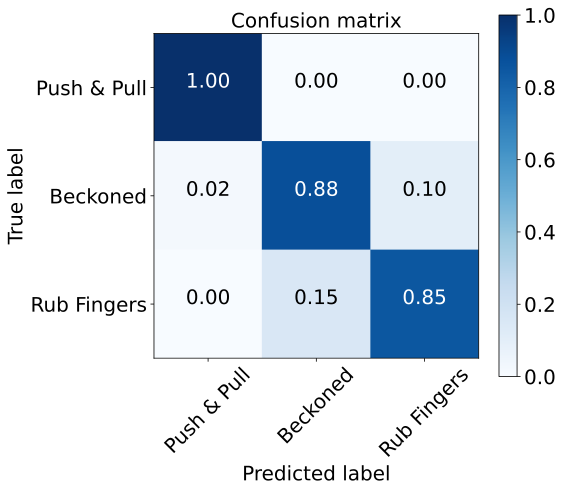

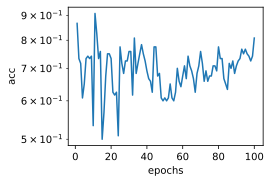

In [10]:
train_gesture(model, train_loader, test_loader,optimizer, device, num_epoch)